In [1]:
import pandas as pd
import numpy as np
from math import pi,e,cos
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

## Preparing data

In [3]:
data = pd.read_csv('wine.csv')
data.dropna(inplace = True)
# data.drop_duplicates(ignore_index = True, inplace = True)

In [4]:
display(data[:5])

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
cols = list(data)
cols.remove('class')
cols.append('class')

In [6]:
data = data.loc[:, cols]

In [7]:
display(data[:5])

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


### Normalizing

In [8]:
def min_max_normalization(column):
    max_value = column.max()
    min_value = column.min()
    return column.apply(lambda x: (x - min_value) / (max_value - min_value))

In [9]:
features = data.iloc[:,0:len(data.columns)-1]
for column in features.columns:
    data[column] = min_max_normalization(data[column])

In [10]:
data[:5]

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline,class
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,1
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,1
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,1
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,1
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,1


## Algo

### Distance functions

In [11]:
def euclidean(M, x, y):
    """
    Args:
        M: Number of features.
        x: Feature vector of first element.
        y: Feature vector of second element.
    """
    dist = 0
    for i in range(M):
        dist += (x[i] - y[i]) ** 2
    return dist ** (1/2)

In [12]:
def manhattan(M, x, y):
    dist = 0
    for i in range(M):
        dist += abs(x[i] - y[i])
    return dist

In [13]:
def chebyshev(M, x, y):
    max_dist = 0
    for i in range(M):
        cur_dist = abs(x[i] - y[i])
        if (max_dist < cur_dist):
            max_dist = cur_dist
    return max_dist

In [14]:
def get_distance_by_name(name):
    if (name == 'euclidean'):
        return euclidean
    elif (name == 'manhattan'):
        return manhattan
    else:
        return chebyshev

### Kernel functions

In [15]:
def uniform(u):
    if (abs(u) >= 1):
        return 0
    return 1/2

In [16]:
def triangular(u):
    if (abs(u) >= 1):
        return 0
    return 1 - abs(u)

In [17]:
def epanechnikov(u):
    if (abs(u) >= 1):
        return 0
    return 3/4 * (1 - u**2)

In [18]:
def quartic(u):
    if (abs(u) >= 1):
        return 0
    return 15/16 * (1 - u**2)**2

In [19]:
def triweight(u):
    if (abs(u) >= 1):
        return 0
    return 35/32 * (1 - u**2)**3

In [20]:
def tricube(u):
    if (abs(u) >= 1):
        return 0
    return 70/81 * (1 - abs(u)**3)**3

In [21]:
def gaussian(u):
    return 1/pi**(1/2) * e**(-1/2 * u**2)

In [22]:
def cosine(u):
    if (abs(u) >= 1):
        return 0
    return pi/4 * cos(pi/2 * u)

In [23]:
def logistic(u):
    return 1/(e**u + 2 + e**(-u))

In [24]:
def sigmoid(u):
    return 2/pi * 1/(e**u + e**(-u))

In [25]:
def get_kernel_by_name(name):
    if (name == 'uniform'):
        return uniform
    elif (name == 'triangular'):
        return triangular
    elif (name == 'epanechnikov'):
        return epanechnikov
    elif (name == 'quartic'):
        return quartic
    elif (name == 'triweight'):
        return triweight
    elif (name == 'tricube'):
        return tricube
    elif (name == 'gaussian'):
        return gaussian
    elif (name == 'cosine'):
        return cosine
    elif (name == 'logistic'):
        return logistic
    else:
        return sigmoid

### Parzen window method naively

In [26]:
def get_target_of_object(N, M, d, q, distance_name, kernel_name, window_type, h):
    """
    Computes real target value of desired object (q).
    """
    distance = get_distance_by_name(distance_name)
    kernel = get_kernel_by_name(kernel_name)
    d = sorted(d, key=lambda x: distance(M, x, q))
    
    target_q = 0
    all_target = []
    all_weight = []
    
    if (window_type != 'fixed'):
        h = distance(M, d[h-1], q)

    if (h == 0):
        if (distance(M, d[0], q) == 0):
            d_equal = list(filter(lambda x: distance(M, x, q) == 0, d))
            target_q = sum(d_equal[i][M] for i in range(len(d_equal))) / len(d_equal)
        else:
            target_q = sum(d[i][M] for i in range(N)) / N
    else:
        all_weight = list(map(lambda x: kernel(distance(M, x, q) / h), d))
        all_target = list(map(lambda x: kernel(distance(M, x, q) / h) * x[M], d))
        target_q = sum(all_target) / sum(all_weight) if (sum(all_weight) != 0) else sum(d[i][M] for i in range(N)) / N
    return target_q 

In [27]:
def get_class_of_object(N, M, d, q, distance_name, kernel_name, window_type, h):
    """
    Find class of object by rounding.
    """
    return round(get_target_of_object(N, M, d, q, distance_name, kernel_name, window_type, h))

### OneHot

In [28]:
def get_onehot_target_of_object(N, M, d, q, distance_name, kernel_name, window_type, h, clases):
    """
    Computes onehot target value (vector) of desired object (q).
    """
    distance = get_distance_by_name(distance_name)
    kernel = get_kernel_by_name(kernel_name)
    d = sorted(d, key=lambda x: distance(M, x, q))
    CN = len(classes)
    
    res = [0 for i in range(CN)]
    
    if (window_type != 'fixed'):
        h = distance(M, d[h-1], q)
        
    if (h == 0):
        if (distance(M, d[0], q) == 0):
            d_equal = list(filter(lambda x: distance(M, x, q) == 0, d))
            for i in range(len(d_equal)):
                res[classes.index(d_equal[i][M])] += 1
        else:
            for i in range(N):
                res[classes.index(d[i][M])] += 1
    else:
        for i in range(N):
            res[classes.index(d[i][M])] += kernel(distance(M, d[i], q) / h)

    return res

In [45]:
def get_onehot_class_of_object(N, M, d, q, distance_name, kernel_name, window_type, h, classes):
    """
    Find class of object by finding max in vector coords.
    """
    res = get_onehot_target_of_object(N, M, d, q, distance_name, kernel_name, window_type, h, classes)
    idx_sorted = sorted(range(len(classes)), key=lambda k: res[k])
    return classes[idx_sorted[len(classes)-1]]

### Confusion matrix with LOO

In [30]:
def get_confusion_matrix(N, M, test_data, distance_name, kernel_name, window_type, h, classes, onehot = False):
    """
    Computes confusion matrix by predicting values of class.
    
    Args:
        N: Number of known objects.
        M: Number of features of object.
        test_data: Dataframe of objects.
        distance_name: Distance function name.
        kernel_name: Kernel function name.
        window_type: Type of window.
        h: Radius of window or number of neighbors.
        classes: Unique classes of data.
        onehot: Use method without/with onehot.
    """
    CN = len(classes)
    matrix = [[0 for i in range(CN)] for j in range(CN)]
    
    for idx in range(N):
        q = test_data.iloc[idx]
        actual_class = test_data.iloc[idx][M]
        train_data = test_data.drop([idx])
        
        if (onehot):
            predicted_class = get_onehot_class_of_object(N-1, M, train_data.values, q, 
                                                         distance_name, kernel_name, window_type, h, classes)
        else:
            predicted_class = get_class_of_object(N-1, M, train_data.values, q, 
                                                  distance_name, kernel_name, window_type, h)
        
        matrix[classes.index(actual_class)][classes.index(predicted_class)] += 1
    return matrix

### F1-score

In [31]:
def find_f1(precision, recall):
    """
    Computes F1-score of given precision and recall.
    """
    if (precision == 0 and recall == 0):
        return 0
    return 2 * precision * recall / (precision + recall)

In [32]:
def find_weight_sum(N, CM, nonweight_list, all_elem):
    """
    Computes weight sum of nonweight_list multiplying each element 
    by the ratio of the number of class elements to the number of elements of all classes.
    """
    weight_sum = 0
    
    for c in range(N):
        all_class = 0
        for i in range(N):
            all_class += CM[c][i]
        weight_sum += nonweight_list[c] * all_class / all_elem
    return weight_sum

In [33]:
def get_macro_micro(N, CM):
    """
    Computes macro F1-score and micro F1-score of given confusion matrix.
    
    A bit of theory:
    
    1. Each row of the confusion matrix represents the instances in a predicted class 
    while each column represents the instances in an actual class.
    2. precision = TP / (TP + FP); recall = TP / (TP + FN)
    Within the matrix (TP + FP) is real values (column) and (TP + FN) is predicted values (row).
    3. micro f1-score is sum of all weight f1-scores
    4. macro f1-score is f1-score of sum of all weight precisions and sum of all weight recalls
    
    Args:
        N: Number of classes.
        CM: Comfusion matrix.
    Returns:
        Macro F1-score and micro F1-score.
"""
    precision = []
    recall = []
    f1 = []
    all_elem = 0
    for c in range(N):
        sum_real = sum_predicted = 0
        for i in range(N):
            sum_real += CM[c][i]
            sum_predicted += CM[i][c]
        all_elem += sum_real
        precision.append(0 if (sum_predicted == 0) else CM[c][c] / sum_predicted)
        recall.append(0 if (sum_real == 0) else CM[c][c] / sum_real)
        f1.append(find_f1(precision[c], recall[c]))

    weight_precision = find_weight_sum(N, CM, precision, all_elem)
    weight_recall = find_weight_sum(N, CM, recall, all_elem)
    weight_f1 = find_weight_sum(N, CM, f1, all_elem)

    micro_f = weight_f1
    macro_f = find_f1(weight_precision, weight_recall)
    return micro_f

## Applying algo

### Parameters

In [34]:
DIST_NAMES = ['euclidean', 'manhattan', 'chebyshev']
KERNEL_NAMES = ['uniform', 'triangular', 'epanechnikov', 
                'quartic', 'triweight', 'tricube', 
                'gaussian', 'cosine', 'logistic', 'sigmoid']
WINDOW_TYPES = ['fixed', 'variable']

In [35]:
dkw = sum(sum([[[(dist, kernel, window) for window in WINDOW_TYPES] 
                for kernel in KERNEL_NAMES] 
               for dist in DIST_NAMES], 
              []), 
          [])

### Finding good params

In [36]:
def find_good_params(N, M, test_data, classes, onehot = False):
    max_f = -1
    good_params = []
    CN = len(classes)
    for (dist, kernel, window) in tqdm(dkw):
        h_range = range(0, N-1, round(N/4)) if (window == 'fixed') else range(1, N-1, round(N/4))
        for h in h_range:
            matrix = get_confusion_matrix(N, M, test_data, dist, kernel, window, h, classes, onehot)
            micro_f = get_macro_micro(CN, matrix)
            if (micro_f > max_f):
                good_params = []
                good_params.append(dist)
                good_params.append(kernel)
                good_params.append(window)
                max_f = micro_f
    return good_params, max_f

In [37]:
def find_max_score(good_params, N, M, test_data, classes, onehot = False):
    (dist, kernel, window) = good_params
    lh = []
    lf = []
    max_h = -1
    max_f = -1
    CN = len(classes)
    for h in tqdm(range(1, N)):
        matrix = get_confusion_matrix(N, M, test_data, dist, kernel, window, h, classes, onehot)
        micro_f = get_macro_micro(CN, matrix)
        lf.append(micro_f)
        lh.append(h)
        if (micro_f > max_f):
            max_f = micro_f
            max_h = h
    good_params.append(max_h)
    return good_params, max_f, lh, lf

### Testing

In [51]:
test_data = data[:150]
N = len(test_data)
M = len(test_data.columns) - 1

In [52]:
classes = test_data['class'].unique().tolist()
classes.sort()

In [53]:
classes

[1, 2, 3]

#### Without onehot

In [54]:
good_params, max_f = find_good_params(N, M, test_data, classes)

100%|██████████| 60/60 [37:34<00:00, 37.58s/it]


In [55]:
good_params, max_f

(['manhattan', 'quartic', 'variable'], 0.9866807405889186)

In [56]:
good_params, max_f, lh, lf = find_max_score(good_params, N, M, test_data, classes)

100%|██████████| 149/149 [25:25<00:00, 10.24s/it]


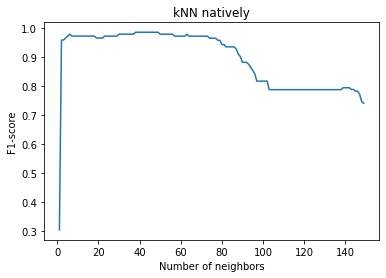

In [63]:
plt.plot(lh, lf)
plt.title('kNN natively')
plt.xlabel('Number of neighbors')
plt.ylabel('F1-score')
plt.show()

#### Onehot

In [58]:
one_good_params, one_max_f = find_good_params(N, M, test_data, classes, True)

100%|██████████| 60/60 [28:37<00:00, 28.63s/it]


In [59]:
one_good_params, one_max_f, one_lh, one_lf = find_max_score(one_good_params, N, M, test_data, classes, True)

100%|██████████| 149/149 [19:36<00:00,  7.90s/it]


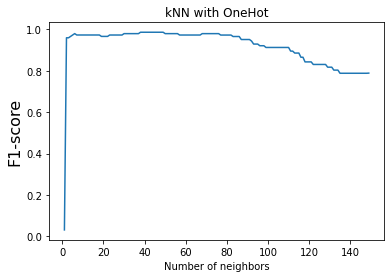

In [64]:
plt.plot(one_lh, one_lf)
plt.title('kNN with OneHot')
plt.xlabel('Number of neighbors')
plt.ylabel('F1-score', fontsize=16)
plt.show()